# Rec Test - Machine Data Analysis v0.2 


## Brief
You have been asked to analyse the data coming from 3 machines from an elementary parts manufacturing plant. The three machines are identical and have all been used to make a single part type. You will be asked to combine and maninpulate the data in order to answer some specific questions.



## Approach
While you can use which ever methods you like in order to achieve this you will need to produce the dataframes/tables as **pandas dataframes** as answers to the questions

Please use function display() for any dataframe/table you are asked to build (i.e. display(df) )

Feel free to make assumptions but please highlight where you have made an assumption.




## Data overview

The data that you have been provided is as follow:
- PartMeasurement.xlsx : An excel file containing the measurements of parts after manufacturing
- PartTolerances.xlsx : An excel file detailing the upper and lower bounds of the meausurements
- MachineHeadInstallations : An excel file containing when a specific machine head was installed on which machine
- MachineRunData : A folder containt json files of machine data per RunID



### Measurement Data

As mentioned all 3 machines are manufacturing the same part. This part has 5 dimensions [A,B,C,D,E] that are measured during a quality inspection at the end of each run. The RunID is a unique identifier (UID) across all machines for an individual machine run and can be treated as the equivalent of a part serial number. Inside the PartMeasurement.xlsx contains the measurements of these 5 dimensions per RunID. The Tolerances for the quality inspection can be found within the PartTolerances.xlsx.

To calculate whether a measurement is within Tolerance, the measurement must be greater or equal to the lower bound AND less than or equal to the upper bound for a given dimension.

All measurements are in mm



### Machine Head Data

There are 3 types of machine heads that are used across all 3 machines:
- A001
- B001
- C001

The 3 Machines are labelled as:
- M01
- M02
- M03

These different machine heads have slightly different machining characteristics and machine settings but can be used to produce the same component.

Each individual machine head has a serialised unique indentifier (UID) called "MachineHeadUniqueReferenceNumber". This UID created by a combination of [Machine Head Type]-[unique iterable reference]. 

Inside the MachineHeadInstallations the machine operators mark the timestamp from when they install a specific machine head into particular machine. This is a tabular format where the Index is the Machine Head UID, the headers are the Machines, and the values in the table is the installation timestamp. 

**Note**:
- A Null value represents the head was not installed on this machine ever
- The machine head can only be installed once and is used until it has be completely used up. 
- The next head is not installed until the previous head on that machine has been used.


### Machine Run Data

The Machine Run Data are Json files corresponding to individual runs. The name of the file is the RunID.

The contents of an individual Json is
- RunID : UID of the Run as discussed above
- MachineRef : Reference of which machine the Run was performed on
- Timestamps : Array of unix timestamps, 1 per second, to indicated when the sensor readings were taken.
- HeadSpeed : Sensor reading of the rotational speed in rpm of the machine head
- HeadTemperature : Sensor reading of the temperature of the machine head 

You can assume that the run starts at the first timestamp and finishes at the final timestamp. The arrays are in the correct sequence meaning, for example, the 5th entry in the HeadTemperature array occured at the 5th entry in the Timestamps array with a headspeed equal to the 5th entry in the HeadSpeed array.




In [284]:
# Import any packages here
import pandas as pd
import json
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Question 1 - Part Quality Control


## Question 1.1
Combine the Measurement data and Tolerance data to produce a dataframe in the format:

 RunID | Dimension | MeasurementValue | TolerancePassOrFail 
 --- | ---- | --- | ----
 R00040121 | A | 10.1 | True 
 R00040121 | B | 28.0 | False 


Each row represents an individual measurement of a dimension per RunID, i.e. there would be 5 rows per RunID. 

Your dataframe can contain more columns than this but must contain these 4. 


**Please display the dataframe at the end using display(df)**


In [285]:
# Load measurement data
df_measurements = pd.read_excel("./Data/PartMeasurements.xlsx", )
display(df_measurements)


,RunID,Measurement_A,Measurement_B,Measurement_C,Measurement_D,Measurement_E
0,R00052321,10.0,25.0,1.5,3.5,100.1
1,R00052322,10.0,25.0,1.5,3.5,100.0
2,R00052323,10.0,25.0,1.5,3.5,100.0
3,R00052324,10.0,25.0,1.5,3.5,100.1
4,R00052325,10.0,25.0,1.5,3.5,100.0
...,...,...,...,...,...,...
2295,R00054508,10.5,25.6,1.6,3.6,104.3
2296,R00054509,10.6,26.4,1.6,3.6,101.3
2297,R00054510,10.0,26.3,1.5,3.6,103.3
2298,R00054511,10.4,26.0,1.5,3.6,102.2


In [286]:

# Load tolerance data
df_tolerances = pd.read_excel("./Data/PartTolerances.xlsx")
display(df_tolerances)

,Measurement,ToleranceLowerBound,ToleranceUpperBound
0,A,9.2,10.8
1,B,23.5,26.5
2,C,1.2,1.8
3,D,3.2,3.8
4,E,95.2,106.2


In [287]:
# Create a copy to avoid modifying the originals
df1 = df_measurements.copy() 
df2 = df_tolerances.copy()    

# Rename columns in df1 for easier reference and to match df2
df1 = df1.rename(columns={
    'Measurement_A': 'A',
    'Measurement_B': 'B',
    'Measurement_C': 'C',
    'Measurement_D': 'D',
    'Measurement_E': 'E'
})

# Reshape df1 from wide format to long format
melted_df = df1.melt(
    id_vars='RunID',           # 'RunID' is kept as an identifier variable
    var_name='Measurement',    # The variable name column will be named 'Measurement'
    value_name='MeasurementValue',  # The values of measurements will be in the 'MeasurementValue' column
    ignore_index=False         # Preserve the original index
)

# Sort the melted DataFrame by 'RunID' for better organization
sorted_df = melted_df.sort_values(by='RunID')

# Merge sorted_df with df2 on the 'Measurement' column
merged_df = pd.merge(
    sorted_df,                # The DataFrame with measurement values
    df2,                      # The DataFrame with tolerance values
    on='Measurement'          # Merge on the 'Measurement' column common to both DataFrames
)

# Calculate PassOrFail for each measurement
merged_df['TolerancePassOrFail'] = (
    (merged_df['MeasurementValue'] >= merged_df['ToleranceLowerBound']) &  # Check if MeasurementValue is above lower bound
    (merged_df['MeasurementValue'] <= merged_df['ToleranceUpperBound'])    # Check if MeasurementValue is below upper bound
)

# Rename columns for clarity
# Store the final result in result_df
first_df = merged_df.rename(columns={'Measurement' : 'Dimension'})

# Display the result DataFrame
display(first_df)


,RunID,Dimension,MeasurementValue,ToleranceLowerBound,ToleranceUpperBound,TolerancePassOrFail
0,R00052321,A,10.0,9.2,10.8,True
1,R00052321,B,25.0,23.5,26.5,True
2,R00052321,E,100.1,95.2,106.2,True
3,R00052321,D,3.5,3.2,3.8,True
4,R00052321,C,1.5,1.2,1.8,True
...,...,...,...,...,...,...
11495,R00054620,C,1.5,1.2,1.8,True
11496,R00054620,A,10.3,9.2,10.8,True
11497,R00054620,D,3.6,3.2,3.8,True
11498,R00054620,B,24.6,23.5,26.5,True


## Question 1.2

Using the dataset you created in Question 1.1 create an aggreated table per Dimension containg the % of components that passed the Tolerance

**Please display the dataframe at the end using display(df)**

In [288]:
# Group by 'Dimension' and calculate the mean of 'TolerancePassOrFail' 
# This mean will represent the percentage of components that passed the tolerance
aggregated_df= first_df.groupby('Dimension')['TolerancePassOrFail'].mean().reset_index()

# Convert the mean to a percentage
aggregated_df['PassPercentage'] = aggregated_df['TolerancePassOrFail'] * 100

# Drop the 'TolerancePassOrFail' column as it's redundant after creating 'PassPercentage'
aggregated_df.drop(columns='TolerancePassOrFail', inplace=True)

# Display the aggregated dataframe
display(aggregated_df)


,Dimension,PassPercentage
0,A,80.826087
1,B,80.086957
2,C,80.869565
3,D,80.826087
4,E,80.391304


## Question 1.3 

Add a new column to the dataset from question 1.1 that normalises the measurement values per dimension from based on the tolerances provided.

The specific normalisation should be a linear normalisation where the normalised value should be -1 at the Lower Bound and 1 and the 1 at the Upper Bound. 

Meaning, using the formula   y = mx +c   (where y is the normalised value and x is the raw value) then the two cases should be:
- m(Tol_UB) + c =  1
- m(Tol_LB) + c = -1

The intention here is to be able to compare the dimensions against each other

[OPTIONAL] You may want to include here other normalisation method of the measurement data for use in question 3

**Please display the dataframe at the end using display(df)**


In [289]:
#Define a function for linear normalization
def linear_normalization(x, lower_bound, upper_bound):
    m = 2 / (upper_bound - lower_bound)
    c = -1 - m * lower_bound
    return m * x + c

# Apply linear normalization per dimension
first_df['NormalizedValue'] = first_df.apply(lambda row: linear_normalization(row['MeasurementValue'], 
                                                                               row['ToleranceLowerBound'], 
                                                                               row['ToleranceUpperBound']), axis=1)

# Display the dataframe with the new column
display(first_df)

,RunID,Dimension,MeasurementValue,ToleranceLowerBound,ToleranceUpperBound,TolerancePassOrFail,NormalizedValue
0,R00052321,A,10.0,9.2,10.8,True,0.000000
1,R00052321,B,25.0,23.5,26.5,True,0.000000
2,R00052321,E,100.1,95.2,106.2,True,-0.109091
3,R00052321,D,3.5,3.2,3.8,True,0.000000
4,R00052321,C,1.5,1.2,1.8,True,0.000000
...,...,...,...,...,...,...,...
11495,R00054620,C,1.5,1.2,1.8,True,0.000000
11496,R00054620,A,10.3,9.2,10.8,True,0.375000
11497,R00054620,D,3.6,3.2,3.8,True,0.333333
11498,R00054620,B,24.6,23.5,26.5,True,-0.266667


# Question 2 - Run Information

## Question 2.1

Create a dataframe that is a stack of the Json files sensor readings with the format:

RunID | MachineRef | Timestamp | HeadSpeed | HeadTemperature 
 --- | ---- | --- | ---- | ----
 R00040121 | M01 | 2022-02-06 07:03:27 | 2001.0 | 200.2
 R00040121 | M01 | 2022-02-06 07:03:27 | 2000.3 | 203.4

**N.B. Timestamp should be a datetime object not unix timestamp**

**Please display the dataframe at the end using display(df)**


In [290]:
# Define the directory containing the JSON files
data_dir = Path("./Data/MachineRunData")

# List all JSON files in the directory
json_files = list(data_dir.glob("*.json"))

# Initialize an empty list to store the data
data = []

# Iterate over each JSON file
for json_file in json_files:
    # Load JSON data
    with open(json_file, "r") as file:
        json_data = json.load(file)
    
    # Extract relevant information
    run_id = json_data["RunID"]
    machine_ref = json_data["MachineRef"]
    timestamps = json_data["Timestamps"]
    head_speed = json_data["HeadSpeed"]
    headtemperature = json_data["HeadTemperature"]
    
    # Create a list of dictionaries for each timestamp, speed and headtemperature
    for timestamp, speed, headtemperature  in zip(timestamps, head_speed, headtemperature):
        data.append({
            "RunID": run_id,
            "MachineRef": machine_ref,
            "Timestamp": timestamp,
            "HeadSpeed": speed,
            "HeadTemperature": headtemperature
        })

# Create a DataFrame
df = pd.DataFrame(data)
# Convert the Timestamp column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

# Display the DataFrame
display(df)


,RunID,MachineRef,Timestamp,HeadSpeed,HeadTemperature
0,R00052321,M01,2023-02-06 07:00:19,1994.6,22.1
1,R00052321,M01,2023-02-06 07:00:20,2001.1,35.2
2,R00052321,M01,2023-02-06 07:00:21,1997.6,47.8
3,R00052321,M01,2023-02-06 07:00:22,2002.5,59.9
4,R00052321,M01,2023-02-06 07:00:23,1994.6,71.5
...,...,...,...,...,...
1429750,R00054620,M01,2023-03-02 19:59:24,1994.2,350.1
1429751,R00054620,M01,2023-03-02 19:59:25,1996.7,350.1
1429752,R00054620,M01,2023-03-02 19:59:26,2005.3,350.1
1429753,R00054620,M01,2023-03-02 19:59:27,1992.6,350.1


In [291]:
df['MachineRef'].value_counts()

MachineRef
M02    486366
M01    475732
M03    467657
Name: count, dtype: int64

NB : Timestamp is a datetime object.

In [292]:
column_types = df.dtypes
print(column_types)


RunID                      object
MachineRef                 object
Timestamp          datetime64[ns]
HeadSpeed                 float64
HeadTemperature           float64
dtype: object


## Question 2.2

Create a dataframe that is an aggregate per RunID of the above with the following Paramters:

- RunID
- MachineRef
- StartTime - The time at which the RunID started
- EndTime - The time at which the RunID ended
- RunLength - The time in seconds of how long the run took
- MeanHeadSpeed - the Mean of the headspeed for that run
- MedianHeadTemperature - the Median temperature of the machine head for that run


**Please display the dataframe at the end using display(df)**

On refait le code de question 2.1

In [293]:
# Initialize an empty list to store the aggregated data
aggregated_data = []

# Iterate over each JSON file
for json_file in json_files:
    # Load JSON data
    with open(json_file, "r") as file:
        json_data = json.load(file)
    
    # Extract relevant information
    run_id = json_data["RunID"]
    machine_ref = json_data["MachineRef"]
    timestamps = json_data["Timestamps"]
    head_speed = json_data["HeadSpeed"]
    head_temperature = json_data["HeadTemperature"]
    
    # Calculate run length
    run_length = timestamps[-1] - timestamps[0]
    
    # Calculate mean head speed
    mean_head_speed = sum(head_speed) / len(head_speed)
    
    # Calculate median head temperature
    median_head_temperature = sorted(head_temperature)[len(head_temperature) // 2]
    
    # Append aggregated data to the list
    aggregated_data.append({
        "RunID": run_id,
        "MachineRef": machine_ref,
        "StartTime": timestamps[0],
        "EndTime": timestamps[-1],
        "RunLength": run_length,
        "MeanHeadSpeed": mean_head_speed,
        "MedianHeadTemperature": median_head_temperature
    })

# Create a DataFrame from the aggregated data
aggregated_df2 = pd.DataFrame(aggregated_data)

# Convert StartTime and EndTime to datetime format
aggregated_df2["StartTime"] = pd.to_datetime(aggregated_df2["StartTime"], unit="s")
aggregated_df2["EndTime"] = pd.to_datetime(aggregated_df2["EndTime"], unit="s")

aggregated_df2 = aggregated_df2.sort_values(by=['MachineRef', 'StartTime'])
# Display the DataFrame
display(aggregated_df2)


,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9
1,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9
2,R00052323,M01,2023-02-06 07:42:11,2023-02-06 07:52:29,618.0,1999.845880,349.9
3,R00052324,M01,2023-02-06 08:02:32,2023-02-06 08:12:43,611.0,2000.449183,350.0
4,R00052325,M01,2023-02-06 08:22:28,2023-02-06 08:32:02,574.0,1999.787304,349.9
...,...,...,...,...,...,...,...
2187,R00054508,M03,2023-03-04 10:44:27,2023-03-04 10:54:55,628.0,1799.986804,349.4
2188,R00054509,M03,2023-03-04 11:06:04,2023-03-04 11:17:05,661.0,1799.982175,349.5
2189,R00054510,M03,2023-03-04 11:27:43,2023-03-04 11:39:02,679.0,1800.076618,349.7
2190,R00054511,M03,2023-03-04 11:51:04,2023-03-04 12:02:36,692.0,1800.222511,349.8


## Question 2.3

Using the aggregated table from question 2.2 join on the Machine Head information that can be found in the MachineHeadInstallation.xlsx.

You should add first the Machine Head unique reference and then parse it to get the Machine Head Type. 


The format should be:


RunID | MachineRef | StartTime | EndTime | Run Length | MeanHeadSpeed | MedianHeadTemperature | MachineHeadUniqueReferenceNumber | MachineHeadType 
 --- | ---- | --- | ---- | ----| ---- | ---- | ---- | ----
 R00040121 | M01 | 2022-02-06 07:03:27 | 2022-02-06 07:08:37 | 310 | 2001.1 | 351.1 | A001-00231 | A001


**Please display the dataframe at the end using display(df)**


In [294]:
# Load the MachineHeadInstallation.xlsx file
machine_head_df = pd.read_excel("./Data/MachineHeadInstallation.xlsx")
display(machine_head_df)


,MachineHeadUniqueReferenceNumber,M01,M02,M03
0,A001-00425,2023-02-06 06:57:19,NaN,NaN
1,A001-00430,NaN,NaN,2023-02-08 16:52:44
2,A001-00431,2023-02-11 08:17:27,NaN,NaN
3,A001-00435,NaN,NaN,2023-02-16 14:43:07
4,A001-00437,NaN,NaN,2023-02-21 14:27:36
5,A001-00441,NaN,NaN,2023-02-24 16:46:28
6,A001-00442,2023-02-23 16:34:11,NaN,NaN
7,A001-00445,2023-02-28 11:14:19,NaN,NaN
8,B001-00426,NaN,2023-02-06 06:57:48,NaN
9,B001-00428,2023-02-08 14:56:42,NaN,NaN


In [295]:
# Melt the DataFrame to reshape it
melted_df = machine_head_df.melt(id_vars='MachineHeadUniqueReferenceNumber', var_name='MachineRef', value_name='StartTime')

# Drop rows with NaN values in StartTime column
melted_df = melted_df.dropna(subset=['StartTime'])
# Sort the DataFrame by StartTime
melted_df = melted_df.sort_values(by='StartTime')

# Reset the index
melted_df = melted_df.reset_index(drop=True)

display(melted_df)
column_types = melted_df.dtypes
print(column_types)

,MachineHeadUniqueReferenceNumber,MachineRef,StartTime
0,A001-00425,M01,2023-02-06 06:57:19
1,B001-00426,M02,2023-02-06 06:57:48
2,C001-00427,M03,2023-02-06 07:01:26
3,B001-00428,M01,2023-02-08 14:56:42
4,A001-00430,M03,2023-02-08 16:52:44
5,C001-00429,M02,2023-02-09 12:28:25
6,A001-00431,M01,2023-02-11 08:17:27
7,C001-00433,M03,2023-02-11 18:33:00
8,B001-00432,M02,2023-02-15 08:19:09
9,B001-00436,M01,2023-02-15 18:47:46


MachineHeadUniqueReferenceNumber    object
MachineRef                          object
StartTime                           object
dtype: object


In [296]:


# Shift the StartTime column within each group of MachineRef to get the end time
# melted_df['EndTime'] =melted_df.groupby('MachineRef')['StartTime'].shift(-1)
# Convert StartTime and EndTime to datetime format
melted_df["StartTime"] = pd.to_datetime(melted_df["StartTime"])
# melted_df["EndTime"] = pd.to_datetime(melted_df["EndTime"])
head_melted_df = melted_df.sort_values(by=['MachineRef', 'StartTime'])
# Display the DataFrame
display(head_melted_df)
column_types = head_melted_df.dtypes
print(column_types)

,MachineHeadUniqueReferenceNumber,MachineRef,StartTime
0,A001-00425,M01,2023-02-06 06:57:19
3,B001-00428,M01,2023-02-08 14:56:42
6,A001-00431,M01,2023-02-11 08:17:27
9,B001-00436,M01,2023-02-15 18:47:46
12,B001-00439,M01,2023-02-18 18:20:08
14,A001-00442,M01,2023-02-23 16:34:11
17,A001-00445,M01,2023-02-28 11:14:19
1,B001-00426,M02,2023-02-06 06:57:48
5,C001-00429,M02,2023-02-09 12:28:25
8,B001-00432,M02,2023-02-15 08:19:09


MachineHeadUniqueReferenceNumber            object
MachineRef                                  object
StartTime                           datetime64[ns]
dtype: object


Here, we supposed the last head on each machine still working. It will give us A NaN in question 3

In [297]:
#Replace NaT with the current time
#melted_df.replace(np.nan, np.inf, inplace=True)
#melted_df['EndTime'] = melted_df['EndTime'].fillna(pd.Timestamp.now().floor('s'))

#melted_df['EndTime'] = melted_df['EndTime'].fillna(melted_df['EndTime'] + timedelta(days=4))
#display(melted_df)

In [298]:
#melted_df['InstalHeadTime'] =  melted_df['EndTime'] - melted_df['StartTime']
# Display the reshaped DataFrame
#display(melted_df)

In [299]:
#column_types = melted_df.dtypes
#print(column_types)


In [300]:
aggregated_df2

,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9
1,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9
2,R00052323,M01,2023-02-06 07:42:11,2023-02-06 07:52:29,618.0,1999.845880,349.9
3,R00052324,M01,2023-02-06 08:02:32,2023-02-06 08:12:43,611.0,2000.449183,350.0
4,R00052325,M01,2023-02-06 08:22:28,2023-02-06 08:32:02,574.0,1999.787304,349.9
...,...,...,...,...,...,...,...
2187,R00054508,M03,2023-03-04 10:44:27,2023-03-04 10:54:55,628.0,1799.986804,349.4
2188,R00054509,M03,2023-03-04 11:06:04,2023-03-04 11:17:05,661.0,1799.982175,349.5
2189,R00054510,M03,2023-03-04 11:27:43,2023-03-04 11:39:02,679.0,1800.076618,349.7
2190,R00054511,M03,2023-03-04 11:51:04,2023-03-04 12:02:36,692.0,1800.222511,349.8


In [301]:
# Merge dataframes based on the condition that the RunID corresponds to the operational time of a head in a machine.
# This is achieved by checking if the RunID start time falls within the working time of a head in a specific machine.
merged_df = pd.merge_asof(
    aggregated_df2.sort_values('StartTime'),  # Sort aggregated_df2 by StartTime
    melted_df.sort_values('StartTime'),       # Sort melted_df by StartTime
    by='MachineRef',                          # Merge on the 'MachineRef' column to ensure matching machine references
    left_on='StartTime',                      # Use 'StartTime' from aggregated_df2 for the merge key
    right_on='StartTime',                     # Use 'StartTime' from melted_df for the merge key
    direction='backward'                      # Merge using the closest previous 'StartTime' from melted_df
)

# Display the merged DataFrame
display(merged_df)


,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature,MachineHeadUniqueReferenceNumber
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9,A001-00425
1,R00052427,M02,2023-02-06 07:00:48,2023-02-06 07:12:20,692.0,1800.076479,349.6,B001-00426
2,R00052529,M03,2023-02-06 07:04:26,2023-02-06 07:14:46,620.0,1300.092271,349.6,C001-00427
3,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9,A001-00425
4,R00052530,M03,2023-02-06 07:26:22,2023-02-06 07:36:39,617.0,1299.917638,349.6,C001-00427
...,...,...,...,...,...,...,...,...
2295,R00054393,M02,2023-03-11 14:02:43,2023-03-11 14:12:44,601.0,1799.378904,349.3,B001-00443
2296,R00054394,M02,2023-03-11 14:29:47,2023-03-11 14:40:36,649.0,1799.929385,349.5,B001-00443
2297,R00054395,M02,2023-03-11 14:57:50,2023-03-11 15:07:45,595.0,1799.545470,349.2,B001-00443
2298,R00054396,M02,2023-03-11 15:25:06,2023-03-11 15:35:51,645.0,1799.498297,349.5,B001-00443


In [302]:

# Filter merged dataframe based on the end time condition
#merged_df = merged_df[(merged_df['EndTime_x'] <= merged_df['EndTime_y'])]
#display(merged_df)


In [303]:

# Rename columns for clarity
#final_df = merged_df.rename(columns={'EndTime_x': 'EndTime', 'StartTime_x': 'StartTime'})
#try:
#    final_df = final_df.drop(labels=['EndTime_y'], axis=1)
#except KeyError:
#   print("Column 'EndTime_y' not found. Skipping drop operation.")


# Add MachineHeadType
merged_df['MachineHeadType'] = merged_df['MachineHeadUniqueReferenceNumber'].str.split('-').str[0]
display(merged_df)

,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature,MachineHeadUniqueReferenceNumber,MachineHeadType
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9,A001-00425,A001
1,R00052427,M02,2023-02-06 07:00:48,2023-02-06 07:12:20,692.0,1800.076479,349.6,B001-00426,B001
2,R00052529,M03,2023-02-06 07:04:26,2023-02-06 07:14:46,620.0,1300.092271,349.6,C001-00427,C001
3,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9,A001-00425,A001
4,R00052530,M03,2023-02-06 07:26:22,2023-02-06 07:36:39,617.0,1299.917638,349.6,C001-00427,C001
...,...,...,...,...,...,...,...,...,...
2295,R00054393,M02,2023-03-11 14:02:43,2023-03-11 14:12:44,601.0,1799.378904,349.3,B001-00443,B001
2296,R00054394,M02,2023-03-11 14:29:47,2023-03-11 14:40:36,649.0,1799.929385,349.5,B001-00443,B001
2297,R00054395,M02,2023-03-11 14:57:50,2023-03-11 15:07:45,595.0,1799.545470,349.2,B001-00443,B001
2298,R00054396,M02,2023-03-11 15:25:06,2023-03-11 15:35:51,645.0,1799.498297,349.5,B001-00443,B001


## Question 2.4

Add a column named "RunRank" which is the rank from earliest run to latest run a given MachineHeadUniqueReferenceNumber. i.e. the first run on a given MachineHead UID should be 1 and the last should be the total number of runs that have been performed on that MachineHead UID

**Please display the dataframe at the end using display(df)**

In [304]:

# Sort by MachineHeadUniqueReferenceNumber and StartTime
final_df = merged_df.sort_values(by=['MachineHeadUniqueReferenceNumber', 'StartTime'])

# Add RunRank column
final_df['RunRank'] = final_df.groupby('MachineHeadUniqueReferenceNumber').cumcount() + 1

# Select and rename columns for the final output
final_df = final_df[['RunID', 'MachineRef', 'StartTime', 'EndTime', 'RunLength', 'MeanHeadSpeed', 'MedianHeadTemperature', 'MachineHeadUniqueReferenceNumber', 'MachineHeadType', 'RunRank']]
display(final_df)

,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature,MachineHeadUniqueReferenceNumber,MachineHeadType,RunRank
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9,A001-00425,A001,1
3,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9,A001-00425,A001,2
6,R00052323,M01,2023-02-06 07:42:11,2023-02-06 07:52:29,618.0,1999.845880,349.9,A001-00425,A001,3
9,R00052324,M01,2023-02-06 08:02:32,2023-02-06 08:12:43,611.0,2000.449183,350.0,A001-00425,A001,4
11,R00052325,M01,2023-02-06 08:22:28,2023-02-06 08:32:02,574.0,1999.787304,349.9,A001-00425,A001,5
...,...,...,...,...,...,...,...,...,...,...
2176,R00054070,M02,2023-03-07 14:18:23,2023-03-07 14:28:42,619.0,1799.941452,415.6,C001-00440,C001,115
2177,R00054071,M02,2023-03-07 14:45:58,2023-03-07 14:56:18,620.0,1800.149114,415.7,C001-00440,C001,116
2178,R00054072,M02,2023-03-07 15:13:00,2023-03-07 15:23:14,614.0,1800.405041,415.7,C001-00440,C001,117
2179,R00054073,M02,2023-03-07 15:40:34,2023-03-07 15:50:57,623.0,1799.986859,415.7,C001-00440,C001,118


# Question 3 - Overall Equipment Effectiveness (OEE)

OEE is a calculation to assess the performance of a given machine. It is made up of 3 factors. 

- Availability: The ratio of time the machine is running vs planned production time
- Performance: The ratio of ideal run time vs actual run time
- Quality: The ratio of good parts vs total parts

Each factor can range between 0 and 1.

#### Availability 

F_Availability = Run Time / Planned Production Time

Run Time is the total amount of time the machine is performing a job during a given period of time. 

Planned production time you can assume that it is the total amount of time the Machines are "active". This particular set of machines are active **Monday to Friday, starting at 07:00 in the morning and finishing at 20:30 in the evening**. 


#### Performance

F_performance = (Ideal Cycle Time x Total Run Count) / Run Time

Run Tims is the same as above. 
Total Run count is the number of runs within the same given period of time. 
For Ideal Cycle Time you can assume **580 seconds** 

#### Quality 

F_quality = Good Run Count / Total Run Count

Good count is the total number of parts/Runs that pass the tolerances quality checks. **note** a "good part" must pass _all_ tolerance quality checks

#### OEE

OEE = F_availability x F_performance x F_quality.



## Question 3.1

Calculate each of the 3 factors and the OEE per machine, per week. The weeks should range from the first active week to the last active week. 

Create a data frame with the format

Machine | YearWeek | F_Availability | F_Performance | F_Quality | OEE 
 --- | ---- | --- | ---- | ----| ---- 
M01 | 2022-03 | 0.95 | 0.98 | 0.98 | 0.91 
M01 | 2022-04 | 0.96 | 0.98 | 0.98 | 0.92


**Please display the dataframe at the end using display(df)**


In [305]:
first_df[first_df['TolerancePassOrFail']== True ].count()

RunID                  9269
Dimension              9269
MeasurementValue       9269
ToleranceLowerBound    9269
ToleranceUpperBound    9269
TolerancePassOrFail    9269
NormalizedValue        9269
dtype: int64

In [306]:
# Apply the custom function to each group defined by 'RunID' and join with final_df
tolerance_pass_count = first_df.groupby('RunID')['TolerancePassOrFail'].sum().reset_index(name='GoodRunCount')

# Apply the condition to replace counts
tolerance_pass_count['GoodRunCount'] = tolerance_pass_count['GoodRunCount'].apply(lambda x: 1 if x == 5 else 0)

# Merge the modified count with final_df
final_df = final_df.merge(tolerance_pass_count, on='RunID', how='left')

# Define the active hours
active_hours_per_day = 13.5  # hours from 07:00 to 20:30
active_seconds_per_week = active_hours_per_day * 5 * 3600  # converting hours to seconds for 5 days

# Add columns for year and week
final_df['YearWeek'] = final_df['StartTime'].dt.strftime('%Y-%U')

final_df = final_df.sort_values(by=['MachineRef', 'YearWeek'])
# Display the resulting DataFrame
display(final_df)


,RunID,MachineRef,StartTime,EndTime,RunLength,MeanHeadSpeed,MedianHeadTemperature,MachineHeadUniqueReferenceNumber,MachineHeadType,RunRank,GoodRunCount,YearWeek
0,R00052321,M01,2023-02-06 07:00:19,2023-02-06 07:10:32,613.0,1999.400326,349.9,A001-00425,A001,1,1,2023-06
1,R00052322,M01,2023-02-06 07:20:38,2023-02-06 07:30:32,594.0,1999.970084,349.9,A001-00425,A001,2,1,2023-06
2,R00052323,M01,2023-02-06 07:42:11,2023-02-06 07:52:29,618.0,1999.845880,349.9,A001-00425,A001,3,1,2023-06
3,R00052324,M01,2023-02-06 08:02:32,2023-02-06 08:12:43,611.0,2000.449183,350.0,A001-00425,A001,4,1,2023-06
4,R00052325,M01,2023-02-06 08:22:28,2023-02-06 08:32:02,574.0,1999.787304,349.9,A001-00425,A001,5,1,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
1653,R00054508,M03,2023-03-04 10:44:27,2023-03-04 10:54:55,628.0,1799.986804,349.4,B001-00444,B001,111,1,2023-09
1654,R00054509,M03,2023-03-04 11:06:04,2023-03-04 11:17:05,661.0,1799.982175,349.5,B001-00444,B001,112,1,2023-09
1655,R00054510,M03,2023-03-04 11:27:43,2023-03-04 11:39:02,679.0,1800.076618,349.7,B001-00444,B001,113,1,2023-09
1656,R00054511,M03,2023-03-04 11:51:04,2023-03-04 12:02:36,692.0,1800.222511,349.8,B001-00444,B001,114,1,2023-09


In [307]:

tolerance_pass_count = first_df.groupby('RunID')['TolerancePassOrFail'].sum().reset_index(name='GoodRunCount')

#Group by MachineRef and YearWeek to calculate run time, total run count, and good run count
weekly_data = final_df.groupby(['MachineRef', 'YearWeek']).agg({
    'RunLength': 'sum',
    'GoodRunCount' : 'sum', # Calculate GoodRunCount 
    'RunID': 'count'  # total run count
}).reset_index().rename(columns={'RunID': 'TotalRunCount'})



# Calculate F_Availability
weekly_data['F_Availability'] = weekly_data['RunLength'] / active_seconds_per_week

# Ideal cycle time in seconds
ideal_cycle_time = 580

# Calculate F_Performance
weekly_data['F_Performance'] = (ideal_cycle_time * weekly_data['TotalRunCount']) / weekly_data['RunLength']

# Calculate F_Quality
weekly_data['F_Quality'] = weekly_data['GoodRunCount'] / weekly_data['TotalRunCount']

# Calculate OEE
weekly_data['OEE'] = weekly_data['F_Availability'] * weekly_data['F_Performance'] * weekly_data['F_Quality']

# Select and rename columns for final output
final_oee_df = weekly_data[['MachineRef', 'YearWeek', 'F_Availability', 'F_Performance', 'F_Quality', 'OEE']].rename(columns={'MachineRef': 'Machine'})

# Display the final dataframe
display(final_oee_df)


,Machine,YearWeek,F_Availability,F_Performance,F_Quality,OEE
0,M01,2023-06,0.617387,0.935577,0.991736,0.572840
1,M01,2023-07,0.519317,0.919220,0.975000,0.465432
2,M01,2023-08,0.519329,0.932986,0.965517,0.467819
3,M01,2023-09,0.298560,0.967333,1.000000,0.288807
4,M02,2023-06,0.468634,0.916771,0.555556,0.238683
5,M02,2023-07,0.394741,0.906987,0.700000,0.250617
6,M02,2023-08,0.381765,0.937813,0.000000,0.000000
7,M02,2023-09,0.381930,0.937409,0.000000,0.000000
8,M02,2023-10,0.371267,0.900042,0.800000,0.267325
9,M03,2023-06,0.563267,0.953432,1.000000,0.537037


-Machine M01 shows good performance and quality metrics consistently. However, its availability is highly variable, which significantly affects the OEE. The highest OEE is observed in week 2023-06 due to the highest availability. Conversely, week 2023-09 has the lowest availability and thus the lowest OEE.

-Machine M02’s OEE is heavily influenced by its quality metric. Weeks 2023-08 and 2023-09 have a quality of 0.000000, resulting in an OEE of 0.000000. The highest OEE in week 2023-10 is still low (0.267325) due to the moderate availability and performance.

-Machine M03 maintains high performance and quality metrics, similar to Machine M01. Its availability is more consistent, leading to a relatively stable OEE. The highest OEE in week 2023-06 is due to the highest availability.

## Question 3.2 

Calculate each of the 3 factors and the OEE for each of the Machine Head UID (MachineHeadUniqueReferenceNumber) over the total period that this head is installed. 


MachineHeadUniqueReferenceNumber | Machine | F_Availability | F_Performance | F_Quality | OEE 
 --- | ---- | --- | ---- | ----| ---- 
C001-00134	 | M01 | 0.95 | 0.98 | 0.98 | 0.91 
B001-00136	 | M01 | 0.96 | 0.98 | 0.98 | 0.92



**Please display the dataframe at the end using display(df)**

We do the same things with a little modification in planned production time

In [308]:
melted_df

,MachineHeadUniqueReferenceNumber,MachineRef,StartTime
0,A001-00425,M01,2023-02-06 06:57:19
1,B001-00426,M02,2023-02-06 06:57:48
2,C001-00427,M03,2023-02-06 07:01:26
3,B001-00428,M01,2023-02-08 14:56:42
4,A001-00430,M03,2023-02-08 16:52:44
5,C001-00429,M02,2023-02-09 12:28:25
6,A001-00431,M01,2023-02-11 08:17:27
7,C001-00433,M03,2023-02-11 18:33:00
8,B001-00432,M02,2023-02-15 08:19:09
9,B001-00436,M01,2023-02-15 18:47:46


In [309]:
print(melted_df.groupby('MachineHeadUniqueReferenceNumber')['StartTime'])

In [310]:
print(melted_df.dtypes) # Check the data types of melted_df.columns

MachineHeadUniqueReferenceNumber            object
MachineRef                                  object
StartTime                           datetime64[ns]
dtype: object


In [311]:
melted_df

,MachineHeadUniqueReferenceNumber,MachineRef,StartTime
0,A001-00425,M01,2023-02-06 06:57:19
1,B001-00426,M02,2023-02-06 06:57:48
2,C001-00427,M03,2023-02-06 07:01:26
3,B001-00428,M01,2023-02-08 14:56:42
4,A001-00430,M03,2023-02-08 16:52:44
5,C001-00429,M02,2023-02-09 12:28:25
6,A001-00431,M01,2023-02-11 08:17:27
7,C001-00433,M03,2023-02-11 18:33:00
8,B001-00432,M02,2023-02-15 08:19:09
9,B001-00436,M01,2023-02-15 18:47:46


In [312]:

melted_df["InstalHeadTime"] = melted_df.groupby('MachineRef')['StartTime'].shift(-1) - melted_df["StartTime"]
display(melted_df)

,MachineHeadUniqueReferenceNumber,MachineRef,StartTime,InstalHeadTime
0,A001-00425,M01,2023-02-06 06:57:19,2 days 07:59:23
1,B001-00426,M02,2023-02-06 06:57:48,3 days 05:30:37
2,C001-00427,M03,2023-02-06 07:01:26,2 days 09:51:18
3,B001-00428,M01,2023-02-08 14:56:42,2 days 17:20:45
4,A001-00430,M03,2023-02-08 16:52:44,3 days 01:40:16
5,C001-00429,M02,2023-02-09 12:28:25,5 days 19:50:44
6,A001-00431,M01,2023-02-11 08:17:27,4 days 10:30:19
7,C001-00433,M03,2023-02-11 18:33:00,4 days 20:10:07
8,B001-00432,M02,2023-02-15 08:19:09,3 days 08:51:25
9,B001-00436,M01,2023-02-15 18:47:46,2 days 23:32:22


We can not caculate the OEE for the last head in each machine.

In [313]:
# Group by MachineHeadUniqueReferenceNumber to calculate run time, total run count, and good run count
head_data= final_df.groupby(['MachineHeadUniqueReferenceNumber', 'MachineRef']).agg({
    'RunLength': 'sum',
    'RunID': 'count',  # total run count
    'GoodRunCount': 'sum'
}).reset_index().rename(columns={'RunID': 'TotalRunCount'})

# Calculate F_Availability

head_data= head_data.merge(melted_df[['MachineHeadUniqueReferenceNumber', 'InstalHeadTime']], on='MachineHeadUniqueReferenceNumber', how='left')


head_data ['InstalHeadTime'] = head_data['InstalHeadTime'].dt.total_seconds().astype(float)

head_data['F_Availability'] = head_data['RunLength'] / head_data ['InstalHeadTime']

# Ideal cycle time in seconds
ideal_cycle_time = 580

# Calculate F_Performance
head_data['F_Performance'] = (ideal_cycle_time * head_data['TotalRunCount']) / head_data['RunLength']

# Calculate F_Quality
head_data['F_Quality'] = head_data['GoodRunCount'] / head_data['TotalRunCount']

# Calculate OEE
head_data['OEE'] = head_data['F_Availability'] * head_data['F_Performance'] * head_data['F_Quality']

# Select and rename columns for final output
final_oee_df = head_data[['MachineHeadUniqueReferenceNumber', 'MachineRef', 'F_Availability', 'F_Performance', 'F_Quality', 'OEE']].rename(columns={'MachineRef': 'Machine'})

# Display the final dataframe
display(final_oee_df)

,MachineHeadUniqueReferenceNumber,Machine,F_Availability,F_Performance,F_Quality,OEE
0,A001-00425,M01,0.314368,0.970252,1.000000,0.305016
1,A001-00430,M03,0.266436,0.968541,1.000000,0.258054
2,A001-00431,M01,0.178254,0.967430,1.000000,0.172448
3,A001-00435,M03,0.158058,0.970441,1.000000,0.153386
4,A001-00437,M03,0.266484,0.968117,1.000000,0.257988
5,A001-00441,M03,0.141187,0.966247,1.000000,0.136421
6,A001-00442,M01,0.156300,0.970832,1.000000,0.151741
7,A001-00445,M01,NaN,0.966711,1.000000,NaN
8,B001-00426,M02,0.235241,0.901266,0.980392,0.207858
9,B001-00428,M01,0.273668,0.891906,0.979798,0.239155


# Question 4 - Exploratory Analysis on drivers of non-quality.


Combine the datasets in a way you seem fit in order and perform an exploratory analysis into factors that appear to be affecting "non-quality" (in this instance non-quality is the measurements that fail the tolerance range). 

The kinds of factors you may want to consider are 
- Machine Head Type
- Machine
- Headspeed & Temperature
- RunRank of the Machine Head
- Length of run 

Performing the analysis on the normalised data is suggested but you can decide what is best for your own analysis. 

Use markdown blocks to make comments on findings.


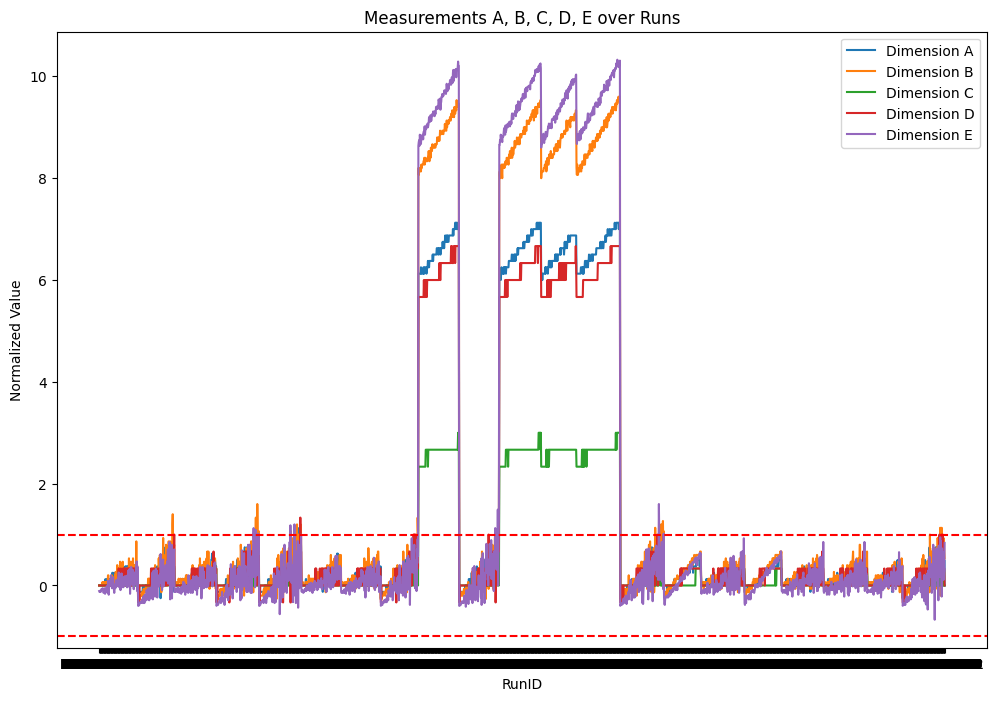

In [314]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge aggregated_df2 and first_df on 'RunID' for each dimension
dimensions = ['A', 'B', 'C', 'D', 'E']
merged_data = {}

for dimension in dimensions:
    merged_data[dimension] = pd.merge(
        aggregated_df2,
        first_df[first_df['Dimension'] == dimension],
        on='RunID'
    )

# Plot the data
plt.figure(figsize=(12, 8))

for dimension in dimensions:
    plt.plot(merged_data[dimension]['RunID'], merged_data[dimension]['NormalizedValue'], label=f'Dimension {dimension}')

# Add labels and title
plt.xlabel('RunID')
plt.ylabel('Normalized Value')
plt.title('Measurements A, B, C, D, E over Runs')

# Add horizontal lines at y = +1 and y = -1
plt.axhline(y=1, color='red', linestyle='--')
plt.axhline(y=-1, color='red', linestyle='--')

# Add legend
plt.legend()

# Show the plot
plt.show()

C:\Users\Rhayoute\AppData\Local\Temp\ipykernel_14024\2272895109.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data, labels=dimensions)


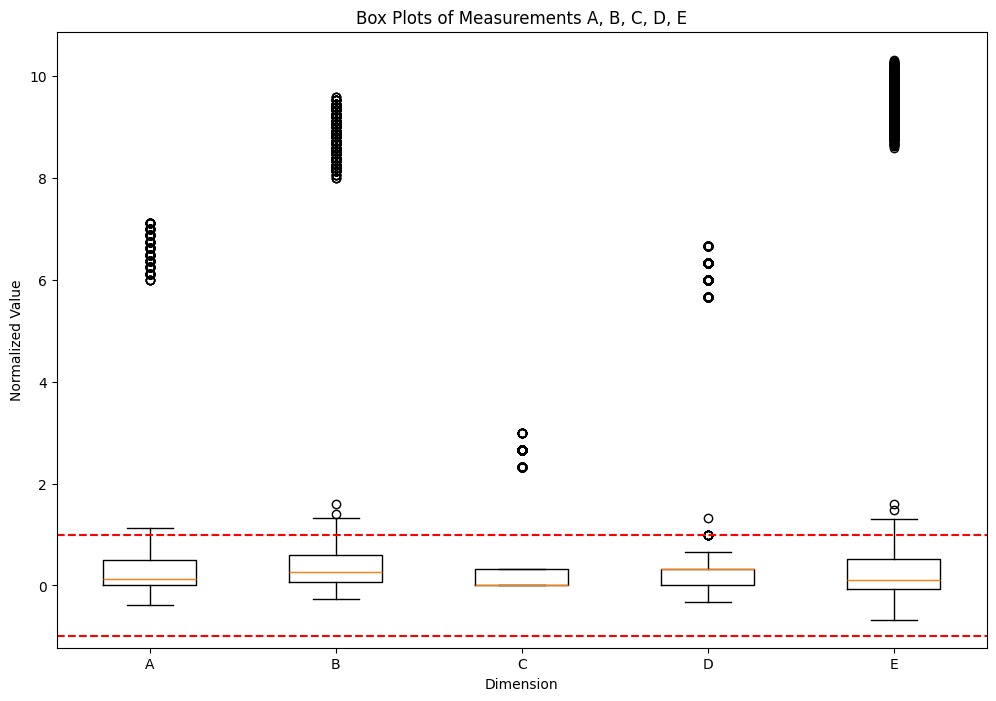

In [315]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume aggregated_df2 and first_df are already defined and loaded with data
# Example of their structure:
# aggregated_df2: DataFrame with 'RunID' and other relevant columns
# first_df: DataFrame with 'RunID', 'Dimension', 'NormalizedValue'

# Merge aggregated_df2 and first_df on 'RunID' for each dimension
dimensions = ['A', 'B', 'C', 'D', 'E']
merged_data = {}

for dimension in dimensions:
    merged_data[dimension] = pd.merge(
        aggregated_df2,
        first_df[first_df['Dimension'] == dimension],
        on='RunID'
    )

# Prepare data for box plots
box_plot_data = [merged_data[dimension]['NormalizedValue'] for dimension in dimensions]

# Create box plots
plt.figure(figsize=(12, 8))

plt.boxplot(box_plot_data, labels=dimensions)

# Add labels and title
plt.xlabel('Dimension')
plt.ylabel('Normalized Value')
plt.title('Box Plots of Measurements A, B, C, D, E')

# Add horizontal lines at y = +1 and y = -1
plt.axhline(y=1, color='red', linestyle='--')
plt.axhline(y=-1, color='red', linestyle='--')

# Show the plot
plt.show()

We say that after a number of good parts, we have a non-quality, and then we go down to good parts.

In [316]:
df = final_df

In [317]:
print(df[df['MachineRef'] =='M01']['GoodRunCount'].value_counts())
print(df[df['MachineRef'] =='M02']['GoodRunCount'].value_counts())
print(df[df['MachineRef'] =='M03']['GoodRunCount'].value_counts())


GoodRunCount
1    752
0     14
Name: count, dtype: int64
GoodRunCount
0    453
1    317
Name: count, dtype: int64
GoodRunCount
1    762
0      2
Name: count, dtype: int64


In [318]:
df.groupby('MachineRef')['GoodRunCount'].sum()

MachineRef
M01    752
M02    317
M03    762
Name: GoodRunCount, dtype: int64

In [319]:
df['MachineRef'].value_counts(sort=False)

MachineRef
M01    766
M02    770
M03    764
Name: count, dtype: int64

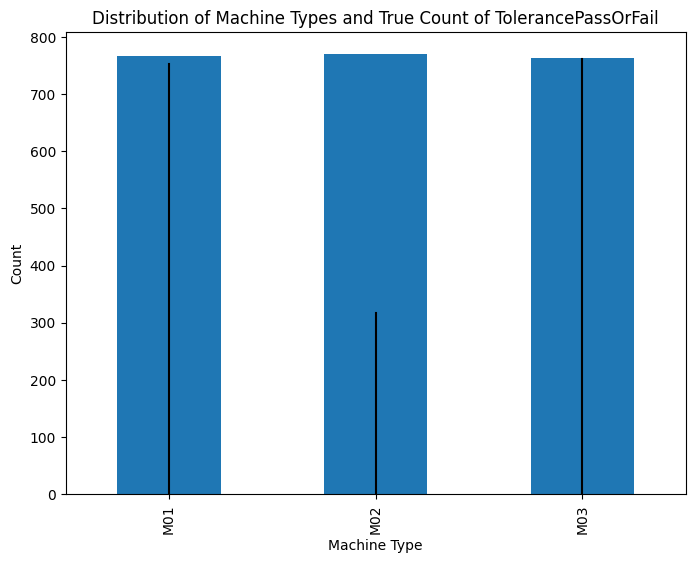

In [320]:
import matplotlib.pyplot as plt

# Count the number of True values in 'TolerancePassOrFail' for each machine type
# Group the DataFrame by 'MachineRef' and count the number of True values in 'TolerancePassOrFail'
counts = df.groupby('MachineRef')['GoodRunCount'].sum().reset_index()

# Visualize the distribution of machine types
plt.figure(figsize=(8, 6))
df['MachineRef'].value_counts(sort=False).plot(kind='bar')

# Add a line plot for the number of True values for each machine type
for index, row in counts.iterrows():
    plt.plot([row['MachineRef'], row['MachineRef']], [0, row['GoodRunCount']], color='black')

plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.title('Distribution of Machine Types and True Count of TolerancePassOrFail')
plt.show()

So the problem seems to come from M2. Let's check what's inside M2. And the one from M1! What is common between the two?

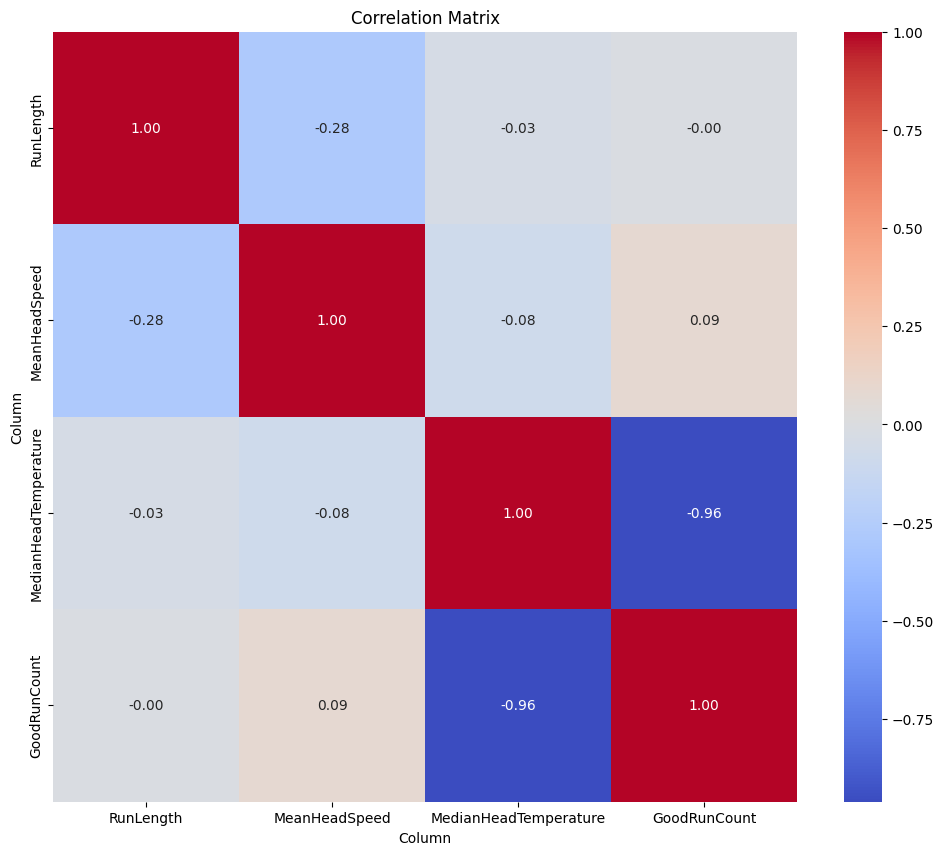

In [321]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the correlation between the selected columns
correlation_matrix = df[['RunLength', 'MeanHeadSpeed', 'MedianHeadTemperature', 'GoodRunCount']].corr()

# Create the correlation plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add labels and title
plt.xlabel('Column')
plt.ylabel('Column')
plt.title('Correlation Matrix')

# Show the plot
plt.show()

When the temperature is higher, the probability of a failure in manufacturing a part increases. We also note that there is no correlation between GoodRunCount and RunLength.

<Figure size 800x600 with 0 Axes>

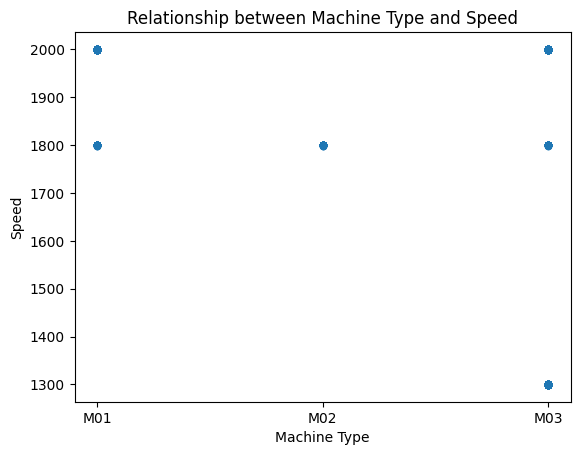

In [322]:
import pandas as pd
import matplotlib.pyplot as plt

# Create scatter plots or boxplots to visualize the relationship between variables and machine types
# For example, if you have a variable called 'speed'
plt.figure(figsize=(8, 6))
df.plot(x='MachineRef', y='MeanHeadSpeed', kind='scatter')
plt.xlabel('Machine Type')
plt.ylabel('Speed')
plt.title('Relationship between Machine Type and Speed')
plt.show()

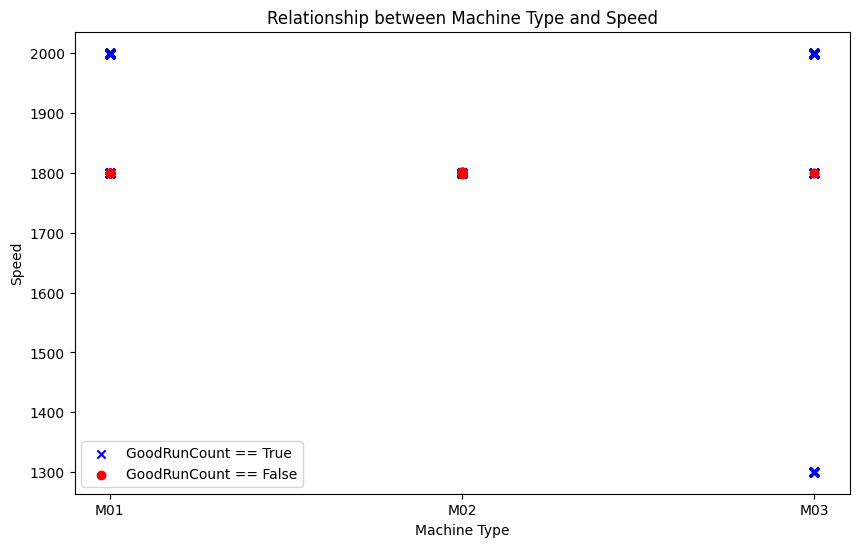

In [323]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate the data based on TolerancePassOrFail being True or False
df_true = df[df['GoodRunCount'] == 1]
df_false = df[df['GoodRunCount'] == 0]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_true['MachineRef'], df_true['MeanHeadSpeed'],marker='x', color='blue', label='GoodRunCount == True')
plt.scatter(df_false['MachineRef'], df_false['MeanHeadSpeed'],marker='o', color='red', label='GoodRunCount == False')
plt.xlabel('Machine Type')
plt.ylabel('Speed')
plt.title('Relationship between Machine Type and Speed')
plt.legend()
plt.show()


We conclude here that the speed has no effect on the quality of parts.

<Figure size 800x600 with 0 Axes>

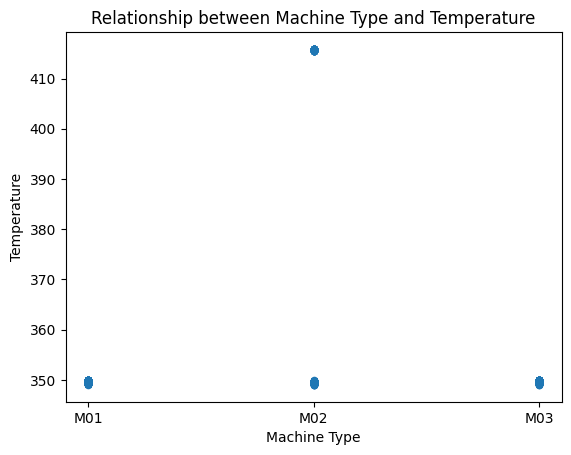

In [324]:
import matplotlib.pyplot as plt

# Create scatter plots or boxplots to visualize the relationship between variables and machine types
plt.figure(figsize=(8, 6))
df.plot(x='MachineRef', y='MedianHeadTemperature', kind='scatter')
plt.xlabel('Machine Type')
plt.ylabel('Temperature')
plt.title('Relationship between Machine Type and Temperature')
plt.show()

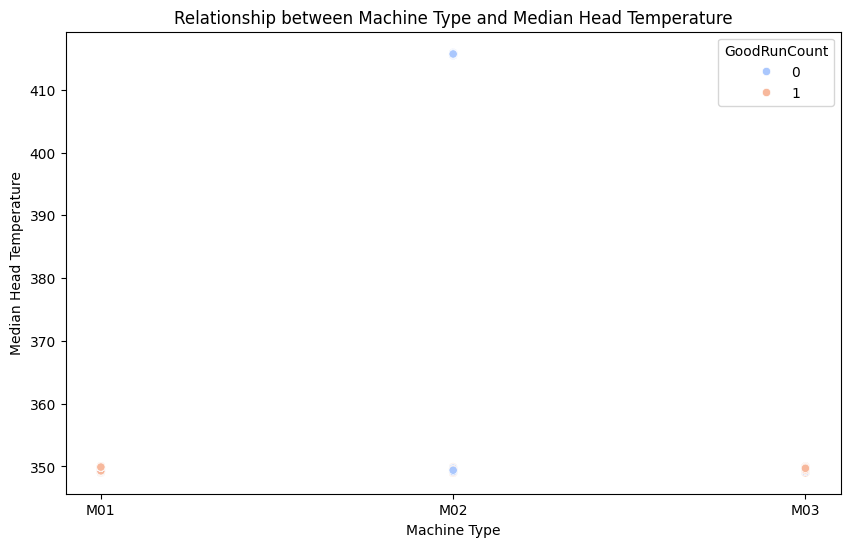

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot to visualize the relationship between MachineRef and MedianHeadTemperature
# with different colors for TolerancePassOrFail being True or False

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MachineRef', y='MedianHeadTemperature', hue='GoodRunCount', palette='coolwarm')
plt.xlabel('Machine Type')
plt.ylabel('Median Head Temperature')
plt.title('Relationship between Machine Type and Median Head Temperature')
plt.show()


Here, we can say yes, but we can also say no because of the temperature of the faulty parts from M1. However, I think the issue with M1 comes from one of the heads getting broken.
Let's check ?

In [326]:
df_m01 = df.loc[(df['MachineRef'] == 'M01') & (df['GoodRunCount'] == 0), ['MachineHeadUniqueReferenceNumber', 'RunRank']]
df_m01['MaxRunRank'] = df_m01.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)

display(df_m01)
df_m03 = df.loc[(df['MachineRef'] == 'M03') & (df['GoodRunCount'] == 0), ['MachineHeadUniqueReferenceNumber', 'RunRank']]
df_m03['MaxRunRank'] = df_m03.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)

display(df_m03)
df_m02 = df.loc[(df['MachineRef'] == 'M02') & (df['GoodRunCount'] == 0), ['MachineHeadUniqueReferenceNumber', 'RunRank']]
df_m02['MaxRunRank'] = df_m02.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)
display(df_m02)


C:\Users\Rhayoute\AppData\Local\Temp\ipykernel_14024\2284609921.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_m01['MaxRunRank'] = df_m01.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)


,MachineHeadUniqueReferenceNumber,RunRank,MaxRunRank
1078,B001-00428,94,95
1079,B001-00428,95,95
1294,B001-00436,102,116
1300,B001-00436,108,116
1304,B001-00436,112,116
1307,B001-00436,115,116
1308,B001-00436,116,116
1394,B001-00439,86,114
1395,B001-00439,87,114
1405,B001-00439,97,114


C:\Users\Rhayoute\AppData\Local\Temp\ipykernel_14024\2284609921.py:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_m03['MaxRunRank'] = df_m03.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)


,MachineHeadUniqueReferenceNumber,RunRank,MaxRunRank
1645,B001-00444,103,107
1649,B001-00444,107,107


C:\Users\Rhayoute\AppData\Local\Temp\ipykernel_14024\2284609921.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_m02['MaxRunRank'] = df_m02.groupby('MachineHeadUniqueReferenceNumber')['RunRank'].transform(max)


,MachineHeadUniqueReferenceNumber,RunRank,MaxRunRank
983,B001-00426,101,102
984,B001-00426,102,102
1759,C001-00429,1,111
1760,C001-00429,2,111
1761,C001-00429,3,111
...,...,...,...
2295,C001-00440,115,119
2296,C001-00440,116,119
2297,C001-00440,117,119
2298,C001-00440,118,119


We see that the NonQuality Parts come from higher 'RunRank' values for M01 and M03, which is not the case for M2. This time, it may be that the higher 'RunRank' values for M01 and M03 are causing the fails.

In [327]:
final_oee_df.loc[final_oee_df['Machine'] == 'M02']

,MachineHeadUniqueReferenceNumber,Machine,F_Availability,F_Performance,F_Quality,OEE
8,B001-00426,M02,0.235241,0.901266,0.980392,0.207858
10,B001-00432,M02,0.242249,0.896547,0.963303,0.209217
13,B001-00443,M02,NaN,0.893625,0.941176,NaN
16,C001-00429,M02,0.136420,0.937391,0.000000,0.000000
18,C001-00434,M02,0.138849,0.937566,0.000000,0.000000
19,C001-00438,M02,0.134470,0.937405,0.000000,0.000000
20,C001-00440,M02,0.142390,0.937734,0.000000,0.000000


In machine M02, the difficulties come from the head machining process, where the quality is equal to zero.

In [328]:
final_oee_df.loc[final_oee_df['Machine'] == 'M03']

,MachineHeadUniqueReferenceNumber,Machine,F_Availability,F_Performance,F_Quality,OEE
1,A001-00430,M03,0.266436,0.968541,1.000000,0.258054
3,A001-00435,M03,0.158058,0.970441,1.000000,0.153386
4,A001-00437,M03,0.266484,0.968117,1.000000,0.257988
5,A001-00441,M03,0.141187,0.966247,1.000000,0.136421
14,B001-00444,M03,NaN,0.899007,0.982609,NaN
15,C001-00427,M03,0.300065,0.937325,1.000000,0.281259
17,C001-00433,M03,0.149419,0.937460,1.000000,0.140074


In [329]:
final_oee_df.loc[final_oee_df['Machine'] == 'M01']

,MachineHeadUniqueReferenceNumber,Machine,F_Availability,F_Performance,F_Quality,OEE
0,A001-00425,M01,0.314368,0.970252,1.000000,0.305016
2,A001-00431,M01,0.178254,0.967430,1.000000,0.172448
6,A001-00442,M01,0.156300,0.970832,1.000000,0.151741
7,A001-00445,M01,NaN,0.966711,1.000000,NaN
9,B001-00428,M01,0.273668,0.891906,0.979798,0.239155
11,B001-00436,M01,0.293315,0.890642,0.956897,0.249979
12,B001-00439,M01,0.173892,0.901157,0.939130,0.147166


We remark that machine head A001 works perfectly for all machines,
and machine head B001 does not work perfectly but is good; 
on the other hand, head C001 it works perfectly for machine M03 but not for machine M02.